# Clustering analysis

In [1]:
import numpy as np
import pandas as pd
from sktime.clustering.k_means import TimeSeriesKMeans
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

import warnings
warnings.filterwarnings('ignore')

## Analysis on a random sample of 500 time-series data

In order to save some time, we can study a random subset of the data.

In [8]:
df = pd.read_csv("df_clean.csv")
df["date"] = pd.to_datetime(df["date"])

df.head()

,Unnamed: 0,date,uuid,ndvi
0,0,2020-01-02,000f5041-32c0-4a8a-b139-83bf4845d9e6,0.661
1,1,2020-01-07,000f5041-32c0-4a8a-b139-83bf4845d9e6,0.661
2,2,2020-01-12,000f5041-32c0-4a8a-b139-83bf4845d9e6,0.655
3,3,2020-01-17,000f5041-32c0-4a8a-b139-83bf4845d9e6,0.597
4,4,2020-01-22,000f5041-32c0-4a8a-b139-83bf4845d9e6,0.559


In [9]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
np.random.seed(11)

uuid_list = df["uuid"].unique().tolist()
uuid_random = np.random.choice(uuid_list, 500, replace=False)

# Random subset consisting of 500 uuid samples
df_random = df[df["uuid"].isin(uuid_random)]

## Transform data to appropriate format 

The `sktime` package fitting algorithms require the dataset to be of the correct format. In this case, we require that the data be in a 'Panel' format, which is nothing but a pandas series with hierarchical indexing. The datatype can also be validated using the `check_is_type` method.

In [11]:
df_transformed = df_random.set_index(["uuid", "date"])[["ndvi"]] # sktime requires hierarchical indexing

df_transformed

ndvi
uuid                                 date             
0098101d-981e-410f-b67f-44e6698382e6 2020-01-02  0.664
                                     2020-01-07  0.664
                                     2020-01-12  0.401
                                     2020-01-17  0.526
                                     2020-01-22  0.468
...                                                ...
ffb92f79-3f18-44cd-819a-329b99f9d4e7 2024-12-06  0.731
                                     2024-12-11  0.757
                                     2024-12-16  0.702
                                     2024-12-21  0.702
                                     2024-12-26  0.668

[182500 rows x 1 columns]

In [14]:
# Validate datatype
from sktime.datatypes import check_is_scitype

check_is_scitype(df_transformed, scitype="Panel", return_metadata=True)

(True,
 '',
 {'is_univariate': True,
  'is_empty': False,
  'has_nans': False,
  'n_features': 1,
  'feature_names': ['ndvi'],
  'dtypekind_dfip': [<DtypeKind.FLOAT: 2>],
  'feature_kind': [<DtypeKind.FLOAT: 2>],
  'n_instances': 500,
  'is_one_series': False,
  'is_equal_length': True,
  'is_equally_spaced': True,
  'n_panels': 1,
  'is_one_panel': True,
  'mtype': 'pd-multiindex',
  'scitype': 'Panel'})

## Dynamic Time Warping (DTW)

The (dis)similarities between time series data is not as simple as computing the Euclidean or Manhattan distances. This is due to the fact that even similar time-series can display lags between their features (crests, troughs etc). For this reasons, we use the concept of 'Dynamic Time Warping' (DTW). The DTW between all time-series data can be aggregated into a DTW matrix, which can be helpful at identifying clusters.

In [32]:
timeseries_dict = {
    series_id: group["ndvi"].values
    for series_id, group in df_transformed.groupby(level=0)
}

In [7]:
from sktime.distances import dtw_distance
from tqdm import tqdm
# from joblib import Parallel, delayed
# from scipy.spatial.distance import squareform
# from scipy.spatial.distance import pdist

timeseries_uuids = list(timeseries_dict.keys())
timeseries_list = list(timeseries_dict.values())

# def calculate_dtw_matrix(ts: list[np.ndarray], n_dim: int) -> np.ndarray:
#     dtw_matrix = np.zeros((n_dim, n_dim))
            
#     for i in tqdm(range(n_dim)):
#         for j in range(1 + 1, n_dim):
#             dist = dtw_distance(ts[i], ts[j])
#             dtw_matrix[i, j] = dist 
#             dtw_matrix[j, i] = dist 
    
#     return dtw_matrix

**Note:** Calculating the DTW matrix is a time-consuming process in a user-defined function. Using `DtwDist()` instead.

In [33]:
# n = len(timeseries_list)

# # Compute DTW pairwise distances
# dtw_matrix = calculate_dtw_matrix(timeseries_list, n)
from sktime.dists_kernels import DtwDist

dtw = DtwDist()
dtw_matrix = dtw.transform(df_transformed)

print(dtw_matrix)

[[0.       3.493458 2.789042 ... 2.099253 4.427991 2.972145]
 [3.493458 0.       3.975279 ... 2.677324 1.016971 1.380756]
 [2.789042 3.975279 0.       ... 3.342924 3.732604 1.763135]
 ...
 [2.099253 2.677324 3.342924 ... 0.       3.397622 2.723183]
 [4.427991 1.016971 3.732604 ... 3.397622 0.       1.189752]
 [2.972145 1.380756 1.763135 ... 2.723183 1.189752 0.      ]]


## DTW heatmap

By plotting the DTW heatmap, we see that the time-series are not 'significantly' different from each other (at least in terms of the DTW metric). The darker bands represent time-series data that are the 'farthest' away in terms of their DTW distances.

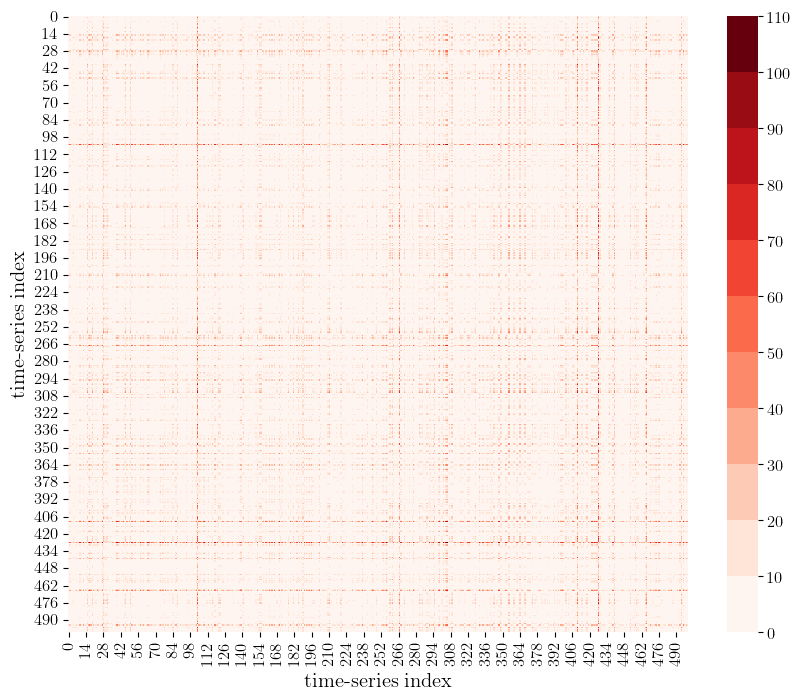

In [35]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

dist_matrix_df = pd.DataFrame(dtw_matrix)

n_bins = 12 # number of discrete color levels
bounds = MaxNLocator(nbins=n_bins).tick_values(dist_matrix_df.min().min(), dist_matrix_df.max().max())
norm = BoundaryNorm(boundaries=bounds, ncolors=256)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(dist_matrix_df, cmap="Reds", norm=norm, cbar_kws={"ticks": bounds}, ax=ax)
ax.set_xlabel("time-series index", fontsize=15)
ax.set_ylabel("time-series index", fontsize=15)
plt.show()

## UMAP for cluster detection

Although it might not be the best practice, we can apply dimensionality reduction algorithms to better detect the presence of clusters in time-series data. The traditional approach would be to use PCA. However, we know that PCA fails in the presence of nonlinear data. As a result, a more logical choice would be UMAP.

In [36]:
df_pivot = df_transformed.reset_index().pivot(index="uuid", columns="date", values="ndvi")

In [41]:
import umap

umap_model = umap.UMAP(
    n_neighbors=12,
    n_components=3, 
    metric="precomputed",
    random_state=10
)
X_umap = umap_model.fit_transform(dtw_matrix)

The time-series sample does display clustering, although not clearly separated. This can also be observed from the DTW heatmap, where the separation between the time-series is shown to be smaller than one would have originally thought.

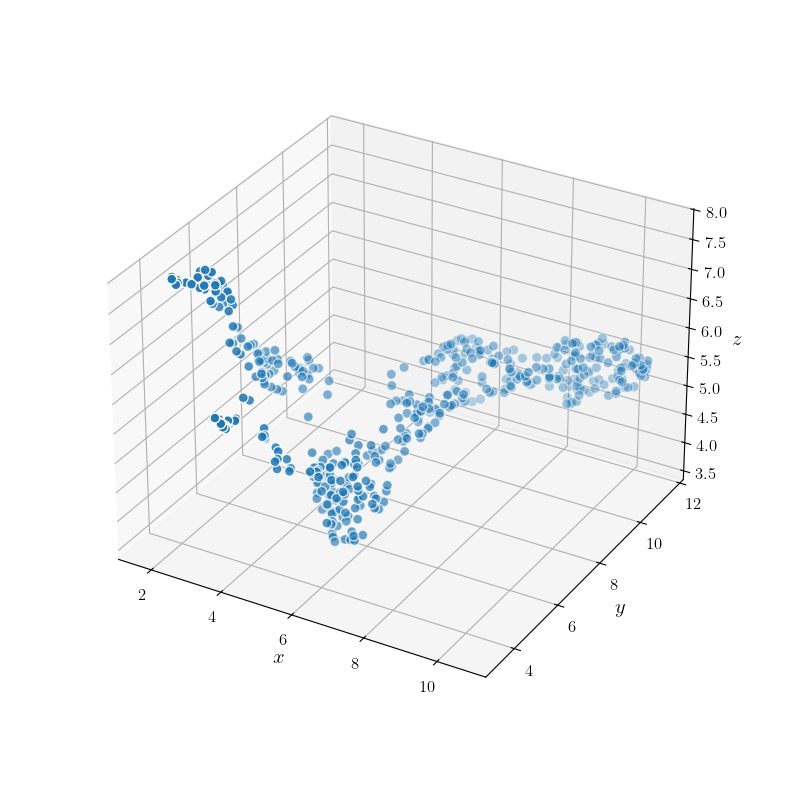

In [42]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    X_umap[:, 2],
    s=50,
    edgecolor='w'
)
ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$y$", fontsize=15)
ax.set_zlabel(r"$z$", fontsize=15)

ax.set_box_aspect(None, zoom=0.85)
plt.show()

## Number of clusters: elbow plot

A good indication of how many clusters the data contains can be obtained from the elbow plot. In the elbow plot, the SSE (sum of squared errors) is plotted as a function of no. of clusters using some algorithm such that the minimum is sought. Using `sktime`'s `TimeSeriesKMeans`, we produce the elbow plot. From the plot, it is not very easy to determin the appropriate value for $n$. Hence, we choose $n=4$.

In [14]:
SSE = []

K= range(2, 8)
for k in K:
    print(k)
    km = TimeSeriesKMeans(
        n_clusters=k,
        metric="dtw",
        verbose=False,
        random_state=10
    )

    km = km.fit(dtw_matrix)
    SSE.append(km.inertia_)

2


KeyboardInterrupt: 

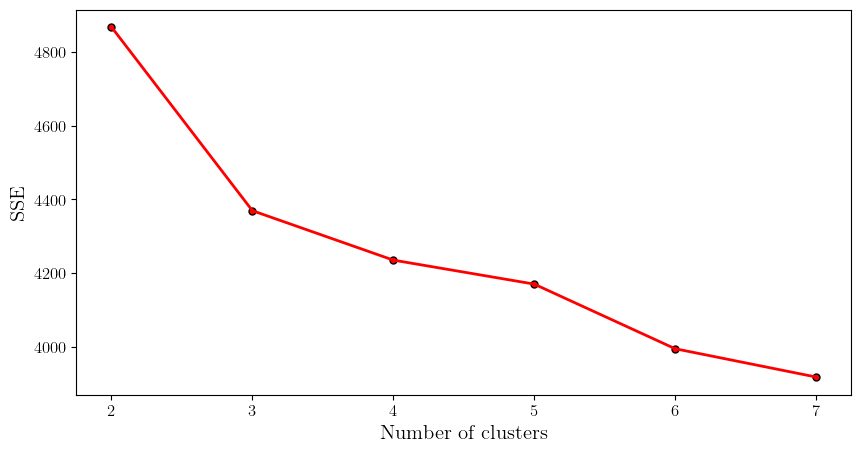

In [129]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(range(2, 8), SSE, s=25, color="r", edgecolor="k")
ax.plot(range(2, 8), SSE, linewidth=2, color="r")
ax.set_xlabel("Number of clusters", fontsize=15)
ax.set_ylabel("SSE", fontsize=15)
plt.show()

**Note:** DBSCAN proved very complicated to implement, will try later if necessary.

In [43]:
def generate_clusters(df: pd.DataFrame, n_clusters: int=6) -> tuple[np.ndarray]:
    """ 
    This function takes in time-series dataframe as input and fits multiple clustering
    algorithms.
    """

    c_1 = TimeSeriesKMeans(
        n_clusters=n_clusters,
        init_algorithm="kmeans++",
        metric="dtw",
        random_state=10
    )

    c_1.fit(df)

    preds_1 = c_1.predict(df)

    return preds_1

In [44]:
preds = generate_clusters(df_transformed)

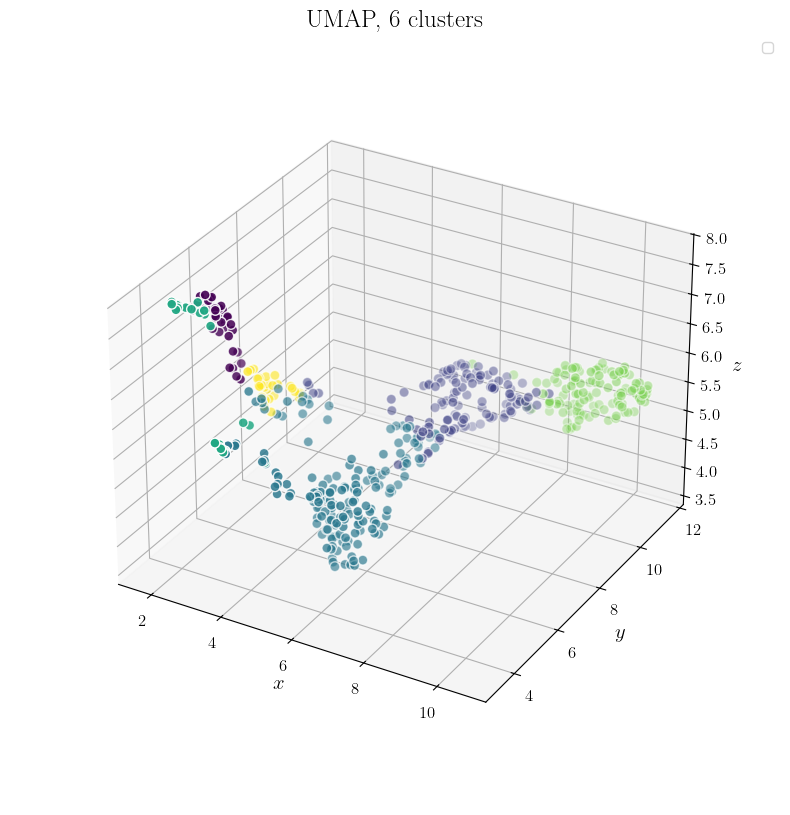

In [49]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    X_umap[:, 2],
    c=preds,
    s=50,
    edgecolor='w'
)
ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$y$", fontsize=15)
ax.set_zlabel(r"$z$", fontsize=15)

ax.set_box_aspect(None, zoom=0.85)
ax.set_title("UMAP, 6 clusters", fontsize=18)
ax.legend()
plt.show()

In [46]:
def add_cluster_label(df: pd.DataFrame, labels: np.ndarray) -> pd.DataFrame:
    uuid_list = df.index.get_level_values(0).unique().tolist()

    label_map = dict(zip(uuid_list, labels))
    # Map label to each row in the DataFrame based on index level 'uuid'
    df["label"] = df.index.get_level_values("uuid").map(label_map)

    df = (
        df.set_index("label", append=True)
          .reorder_levels(["uuid", "label", "date"])
    )

    return df

df_transformed_labeled = add_cluster_label(df_transformed, preds)

df_transformed_labeled.head()

ndvi
uuid                                 label date             
0098101d-981e-410f-b67f-44e6698382e6 2     2020-01-02  0.664
                                           2020-01-07  0.664
                                           2020-01-12  0.401
                                           2020-01-17  0.526
                                           2020-01-22  0.468

In [47]:
def plot_timeseries_clusters(df: pd.DataFrame) -> None:
    df = df.reset_index()

    # df_samples = []
    # for i in range(4):
    #     uuid_random = np.random.choice(df[df["label"]==i]["uuid"].unique(), 5, replace=False)
    #     df_samples.append(df[df["uuid"].isin(uuid_random)])

    fig, ax = plt.subplots(6, 1, figsize=(15, 30), sharex=True)

    for idx, (_, group) in enumerate(df.groupby("uuid")):
        if (group["label"] == 0).all():
            sns.lineplot(group, x="date", y="ndvi", ax=ax[0], c="gray", alpha=0.25).set_title("Cluster 0")
        elif (group["label"] == 1).all():
            sns.lineplot(group, x="date", y="ndvi", ax=ax[1], c="gray", alpha=0.25).set_title("Cluster 1")
        elif (group["label"] == 2).all():
            sns.lineplot(group, x="date", y="ndvi", ax=ax[2], c="gray", alpha=0.25).set_title("Cluster 2")
        elif (group["label"] == 3).all():
            sns.lineplot(group, x="date", y="ndvi", ax=ax[3], c="gray", alpha=0.25).set_title("Cluster 3")
        elif (group["label"] == 4).all():
            sns.lineplot(group, x="date", y="ndvi", ax=ax[4], c="gray", alpha=0.25).set_title("Cluster 4")
        else:
            sns.lineplot(group, x="date", y="ndvi", ax=ax[5], c="gray", alpha=0.25).set_title("Cluster 5")

    c_1 = c_2 = c_3 = c_4 = c_5 = c_6 = 0
    for idx, (_, group) in enumerate(df.groupby("uuid")):
        if (group["label"] == 0).all():
            if c_1 < 3:
                sns.lineplot(group, x="date", y="ndvi", ax=ax[0], linewidth=2).set_title("Cluster 0")
                c_1 += 1
        elif (group["label"] == 1).all():
            if c_2 < 3:
                sns.lineplot(group, x="date", y="ndvi", ax=ax[1], linewidth=2).set_title("Cluster 1")
                c_2 += 1
        elif (group["label"] == 2).all():
            if c_3 < 3:
                sns.lineplot(group, x="date", y="ndvi", ax=ax[2], linewidth=2).set_title("Cluster 2")
                c_3 += 1
        elif (group["label"] == 3).all():
            if c_4 < 3:
                sns.lineplot(group, x="date", y="ndvi", ax=ax[3], linewidth=2).set_title("Cluster 3")
                c_4 += 1
        elif (group["label"] == 4).all():
            if c_5 < 3:
                sns.lineplot(group, x="date", y="ndvi", ax=ax[4], linewidth=2).set_title("Cluster 4")
                c_5 += 1
        else:
            if c_6 < 3:
                sns.lineplot(group, x="date", y="ndvi", ax=ax[5], linewidth=2).set_title("Cluster 5")
                c_6 += 1
            
    plt.show()

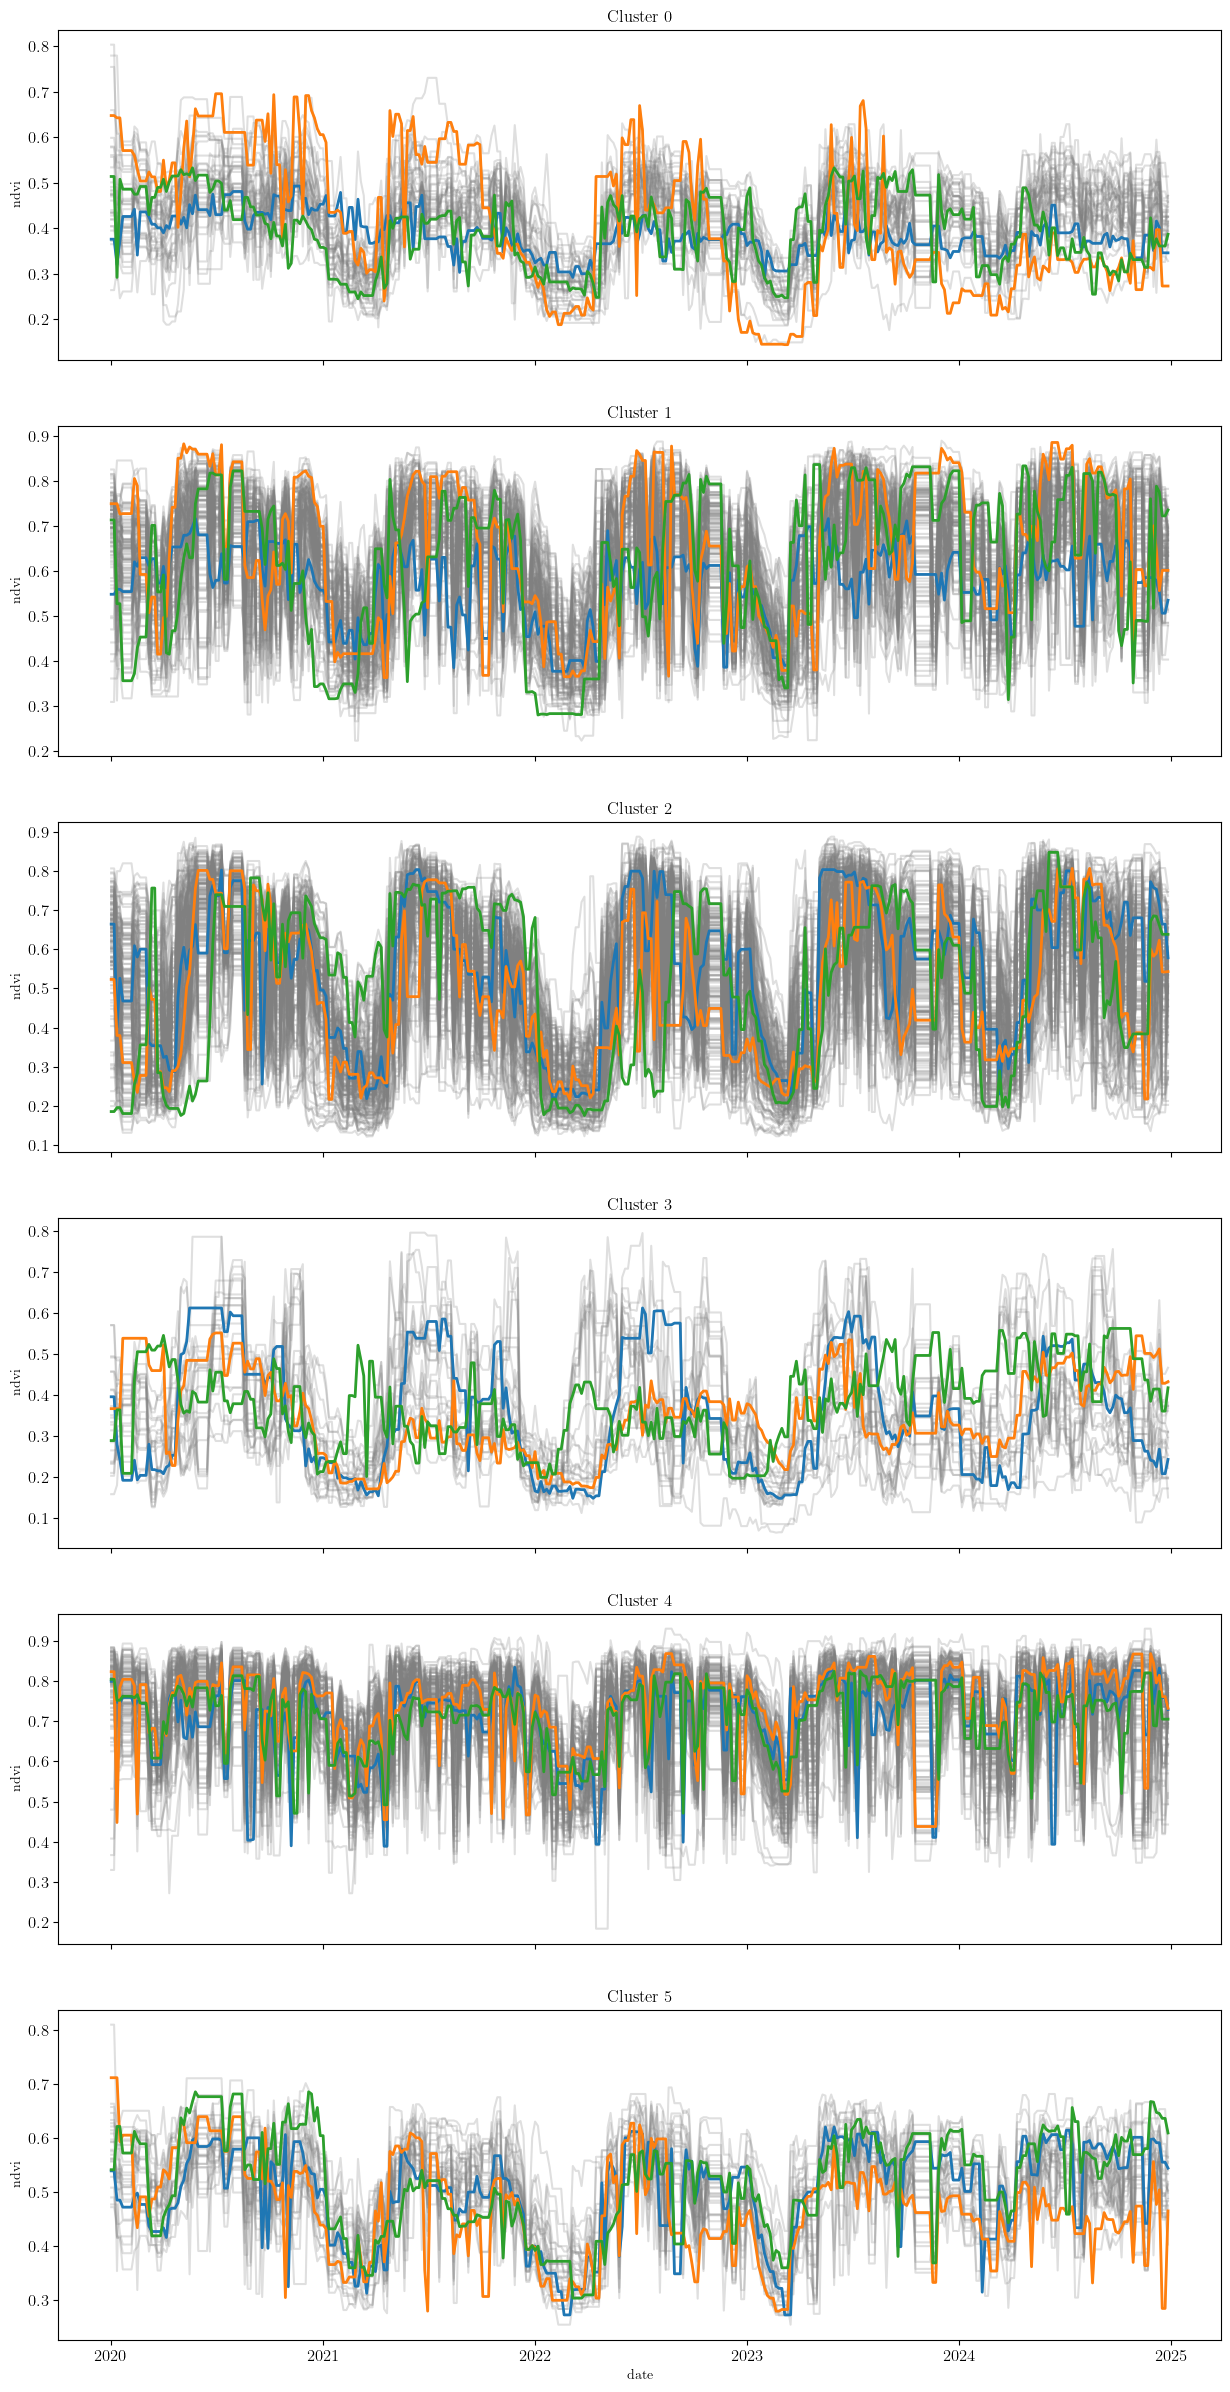

In [48]:
plot_timeseries_clusters(df_transformed_labeled)